In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

**Exercise 1 - New York Point Of Interest**

**(1)**

In [2]:
#import main file of poi
df = pd.read_csv('pois_all_info', sep = '\t', low_memory=False)

#import file for the poi of NYC
nyPOI = pd.read_csv('ny_municipality_pois_id.csv', names = ['@id'])

#keep only poi of NYC by comparing the two files
df = pd.merge(df,nyPOI)
df

,@id,@type,@lat,@lon,amenity,name,shop,public_transport,highway
0,42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
1,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
2,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
3,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
4,42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN
...,...,...,...,...,...,...,...,...,...
53545,2553096114,node,40.736006,-73.713202,NaN,NaN,NaN,NaN,NaN
53546,2553096138,node,40.736020,-73.713063,NaN,NaN,NaN,NaN,NaN
53547,2553096143,node,40.736024,-73.713047,NaN,NaN,NaN,NaN,NaN
53548,2553096154,node,40.736030,-73.713089,NaN,NaN,NaN,NaN,NaN


**(2)** Count the number of missing values for each column

In [3]:
df.isnull().sum()

@id                     0
@type                   0
@lat                    0
@lon                    0
amenity             28838
name                23000
shop                44833
public_transport    45174
highway             45991
dtype: int64

**(3)**

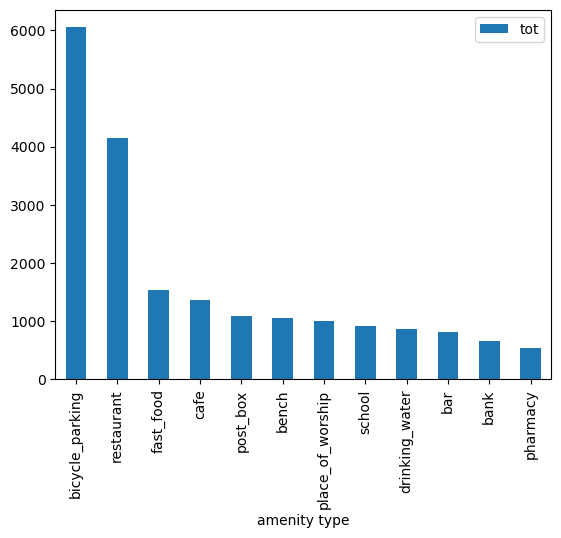

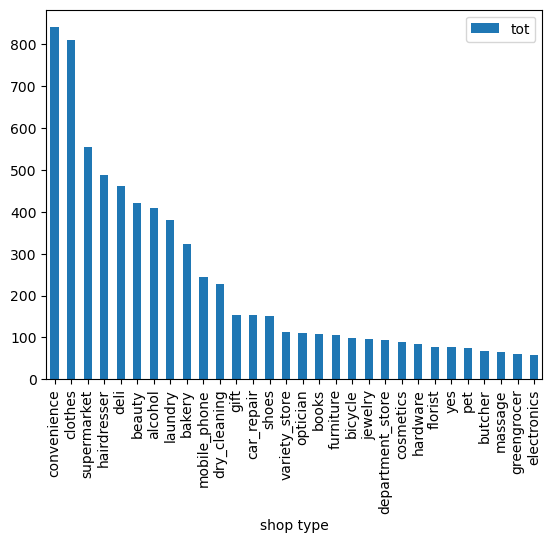

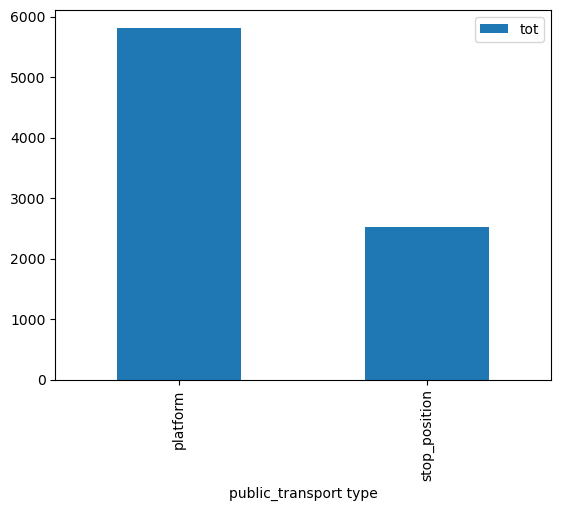

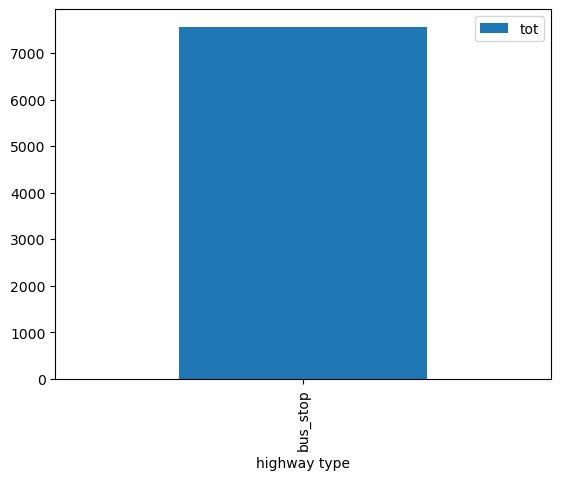

In [4]:
def get_top_perc(series, perc_value = 0.8):
    perc = series.cumsum() / series.sum()
    arg = (perc > perc_value).values.argmax()
    return series.iloc[:arg+1]

categories = ['amenity', 'shop', 'public_transport', 'highway']
for col in categories:
    perc = 0.8
    s = df[col].value_counts()
    sf = get_top_perc(s,perc)
    dfTmp = pd.DataFrame({col + ' type':sf.index, 'tot':sf.values})
    dfTmp.plot.bar(x = col + ' type')


**(4)** Show the points of interest on the New York map for a given category (e.g. amenity).

In [5]:
from matplotlib.cm import get_cmap

class Map:
    def __init__(self, df):
        self.pois_df = df
        self.long_min = df['@lon'].min()
        self.long_max = df['@lon'].max()
        self.lat_min = df['@lat'].min()
        self.lat_max = df['@lat'].max()
    
    def plot_map(self):
        fig, ax = plt.subplots()
        nyc_img = plt.imread('./New_York_City_Map.PNG')
        ax.imshow(nyc_img, zorder=0, extent=[self.long_min,
                                             self.long_max,
                                             self.lat_min,
                                             self.lat_max])
        ax.grid(False)
        return ax
    
    def plot_pois(self, ax, category, mask):
        df = self.pois_df.loc[mask]
        
    # Version 1: using pandas
        types = df[category].unique()
        cmap = get_cmap('viridis')
        colors = cmap(np.linspace(0, 1, types.size))
        for i, t in enumerate(types):
            df_t = df.loc[df[category] == t]
            c = [colors[i]] *  df_t.shape[0]
            df_t.plot.scatter(x='@lon', y='@lat', ax=ax, c=c, alpha=.6, label=t)
            
        ax.legend()
        ax.grid(False)
        return ax

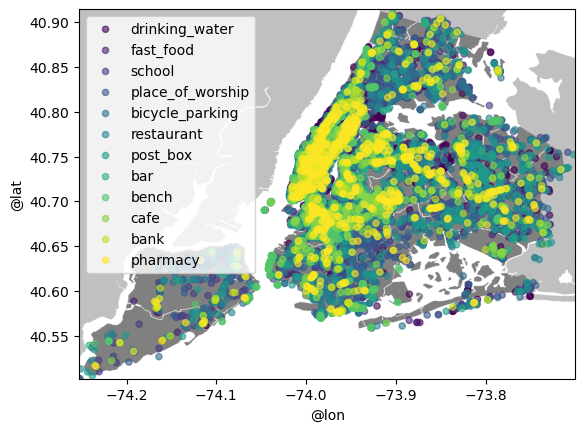

In [6]:
def show_category_on_map(df, column, perc_value):
    """
    Plot the New York map with POIs of a specific category.
    Only the top 'perc_value'% frequent types are plotted.
    """
    counts = df[column].value_counts()
    top_freq = get_top_perc(counts, perc_value)
    ny_map = Map(df)
    
    ax = ny_map.plot_map()
    mask = df[column].isin(top_freq.index)
    ny_map.plot_pois(ax, column, mask)

show_category_on_map(df, 'amenity', .8)

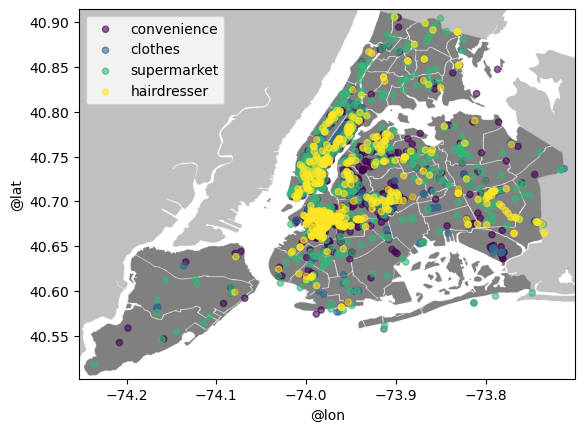

In [7]:
show_category_on_map(df, 'shop', .3)

**(5)**

In [8]:
class Cell_converter:
    def __init__(self, df, n_splits):
        self.lat_min = df['@lat'].min()
        self.lat_max = df['@lat'].max()
        self.long_min = df['@lon'].min()
        self.long_max = df['@lon'].max()
        self.n_splits = n_splits
    
    def plot_grid(self, ax):
        lat_steps = np.linspace(self.lat_min, self.lat_max, self.n_splits + 1)
        long_steps = np.linspace(self.long_min, self.long_max, self.n_splits + 1)
        ax.hlines(lat_steps, self.long_min, self.long_max)
        ax.vlines(long_steps, self.lat_min, self.lat_max)
    
    def point_to_cell_coord(self, long, lat):
        x = int((long - self.long_min)/(self.long_max - self.long_min)*self.n_splits)
        y = int((lat - self.lat_min)/(self.lat_max - self.lat_min)*self.n_splits)
        return x, y
    
    def point_to_cell_id(self, long, lat):
        x, y = self.point_to_cell_coord(long, lat)
        return y * n_splits + x

n_splits = 20
cell_conv = Cell_converter(df, n_splits)

df['cell_id'] = df.apply(lambda x: cell_conv.point_to_cell_id(x['@lon'], x['@lat']), axis=1)
df.head()

,@id,@type,@lat,@lon,amenity,name,shop,public_transport,highway,cell_id
0,42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN,310
1,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN,250
2,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN,337
3,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN,353
4,42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN,197


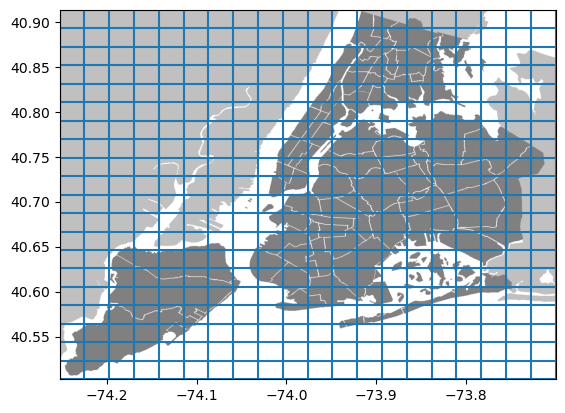

In [9]:
yet_another_map = Map(df)
ax = yet_another_map.plot_map()
cell_conv.plot_grid(ax)

**(6)**

In [10]:
def get_df_count(df, column, perc_value):
    counts = df[column].value_counts()
    top_freq = get_top_perc(counts, perc_value)
    mask = df[column].isin(top_freq.index)
    freq_df = df.loc[mask]

    # for each cell_id count the number of POIs for each type
    count_dframe = []
    for cell_id in range(n_splits**2):
        count_vals = freq_df.loc[freq_df['cell_id'] == cell_id][column].value_counts()
        count_vals.name = cell_id
        count_dframe.append(count_vals)

    cells_features_df = pd.DataFrame(count_dframe)
    cells_features_df = cells_features_df.fillna(0)
    return cells_features_df

In [11]:
amenities_df = get_df_count(df, 'amenity', 0.6)
amenities_df

,restaurant,post_box,fast_food,bicycle_parking,cafe,bench
0,2.0,2.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0


**(7)**

In [12]:
shops_df = get_df_count(df, 'shop', .6)
final_df = pd.concat([amenities_df, shops_df], axis=1)

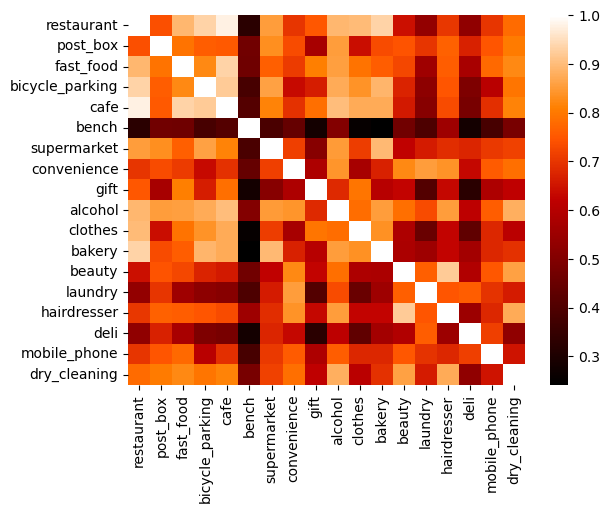

In [13]:
#Metodo mio
cols = list(final_df.columns)
d = dict()
for ci in cols:
    for cj in cols:
        correlation = np.corrcoef(final_df[ci], final_df[cj])[0][1]
        if ci in d:
            d[ci].append(correlation)
        else:
            d[ci] = [correlation]

corrDf = pd.DataFrame(d, index = cols)
ax = sns.heatmap(corrDf, cmap = 'gist_heat' )
plt.show()

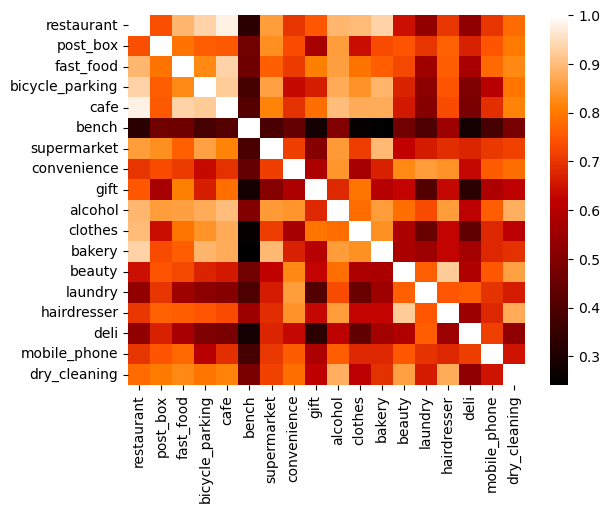

In [14]:
#Easier way using a pandas method

final_corr = final_df.corr()
ax = sns.heatmap(final_corr, cmap = 'gist_heat' )
plt.show()

___
**Exercise 2 - Flight Delay Data**

**(1) Load the data**

In [15]:
dfFlightDelay = pd.read_csv("dataEx2\831394006_T_ONTIME.csv")

In [16]:
dfFlightDelay

,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
0,2017-01-01,AA,19805,N787AA,1,12478,1247803,31703,JFK,"New York, NY",...,1209.0,27.0,0.0,NaN,27.0,0.0,0.0,0.0,0.0,NaN
1,2017-01-01,AA,19805,N783AA,2,12892,1289204,32575,LAX,"Los Angeles, CA",...,1809.0,42.0,0.0,NaN,34.0,0.0,8.0,0.0,0.0,NaN
2,2017-01-01,AA,19805,N791AA,4,12892,1289204,32575,LAX,"Los Angeles, CA",...,2040.0,42.0,0.0,NaN,7.0,0.0,0.0,0.0,35.0,NaN
3,2017-01-01,AA,19805,N391AA,5,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",...,1749.0,97.0,0.0,NaN,77.0,0.0,20.0,0.0,0.0,NaN
4,2017-01-01,AA,19805,N346AA,6,13830,1383002,33830,OGG,"Kahului, HI",...,642.0,42.0,0.0,NaN,0.0,0.0,42.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450012,2017-01-31,NK,20416,N625NK,596,11697,1169704,32467,FLL,"Fort Lauderdale, FL",...,142.0,62.0,0.0,NaN,0.0,0.0,62.0,0.0,0.0,NaN
450013,2017-01-31,NK,20416,N613NK,597,13487,1348702,31650,MSP,"Minneapolis, MN",...,436.0,-13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450014,2017-01-31,NK,20416,N505NK,600,10397,1039705,30397,ATL,"Atlanta, GA",...,2136.0,-7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450015,2017-01-31,NK,20416,N505NK,600,11697,1169704,32467,FLL,"Fort Lauderdale, FL",...,1844.0,-20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
